In [1]:
import sys
import matplotlib.pyplot as plt
from contextualbandits import online as cb
from copy import deepcopy as clone
import numpy as np
import pandas as pd
# The only classifiers that have partial_fit
# See: https://scikit-learn.org/0.15/modules/scaling_strategies.html
from sklearn.linear_model import SGDClassifier
#, PassiveAggressiveClassifier, Perceptron
# from sklearn.naive_bayes import MultinomialNB, BernoulliNB
sys.path.append("../src")

%matplotlib inline

In [23]:
pd.set_option('display.max_columns', None)

In [2]:
# desired_win_rate=0.33



def load_dataframe(data_path='../data/data.csv'):
    """This function gets a data path, loads data and returns a DataFrame accordingly"""
    df = pd.read_csv(data_path) # load
    df = df.query("placementType=='banner' and bidPrice<2 and bidPrice>0.1").sample(frac=0.02) ## TODO: move to databricks notebook
    return df


df = load_dataframe()

# Read data & preprocess

In [3]:
def keep_values_by_min_freq(df, col, freq=0.9,other="OTHER"):
    ds = df[col].value_counts(normalize=True).cumsum()
    mapped2other = []
    marked_as_other = False
    for val, prop in ds.iteritems():
        if marked_as_other:
            mapped2other.append(val)
        if prop>freq:
            marked_as_other=True
    df.loc[df[col].isin(mapped2other), col]=other
    df[col] = df[col].astype('category')
    
    return df

In [4]:
def preprocess(df):
    df = df.drop("sessionId", axis=1)
    df["eventTimestamp"] = pd.to_datetime(df["eventTimestamp"]*1_000_000)
#     df["day_of_week"]=df["eventTimestamp"].dt.weekday.astype("category")
#     df["time_of_day"]=df["eventTimestamp"].dt.hour.astype("category")
    df.sort_values(by='eventTimestamp', inplace=True)
    df = df.drop("eventTimestamp", axis=1)
    print(df.head())
    print(df.columns)
    for col, dtype in df.dtypes.iteritems():
        if str(dtype) == 'object':
            df = keep_values_by_min_freq(df, col)
    
#     df = keep_values_by_min_freq(df, 'adNetworkId')
#     df = keep_values_by_min_freq(df, 'userTrackingAuth')
    # a, r, X for models
    df["arms"] = df["bidPrice"].round(2)
    arms = sorted(list(df["arms"].unique()))
    # Add the logic of: "If $5 won, then $6 would have won as well" (also for loss)
    df["arms"] = df.apply(lambda row: [a for a in arms if a>=row["arms"]] if row["hasWon"] else
                          [a for a in arms if a<=row["arms"]],axis=1)
    df = df.explode("arms")
    arm_dict = {a:i for i, a in enumerate(arms)}
    a = df["arms"].map(arm_dict)
    r = df["hasWon"]
    b = df['bidPrice']
    df = df.drop(["bidPrice", "hasWon", "arms"] ,axis=1)
    df["dnt"] = df["dnt"].astype(object)
    df["userTrackingAuth"] = df["userTrackingAuth"].astype(object)
    df["adNetworkId"] = df['adNetworkId'].astype(object)
    X = pd.get_dummies(df)
    return arm_dict, X, a, r, b

# def preprocess_only_one_feature(df, feature='deviceOs'):
#     # preprocess
#     df = df[['bidPrice', 'hasWon', feature]]
#     df["arms"] = df["bidPrice"].round(1)
#     arms = sorted(list(df["arms"].unique()))
#     # Add the logic of: "If $5 won, then $6 would have won as well" (also for loss)
#     df["arms"] = df.apply(lambda row: [a for a in arms if a>=row["arms"]] if row["hasWon"] else
#                           [a for a in arms if a<=row["arms"]],axis=1)
#     df = df.explode("arms")
    
#     arm_dict = {a:i for i, a in enumerate(arms)}
#     a = df["arms"].map(arm_dict)
#     r = df["hasWon"]
#     df = df.drop(["bidPrice", "hasWon", "arms"] ,axis=1)
#     X = pd.get_dummies(df)
    
#     return arm_dict, X, a, r


# sample
### Note for arms - we should know in advance, per each context, what is the maximum bid
# e.g. for iOS, size=320x50, plc=Banner, we should know that 10 is the maximum and not create an arm for X>10...
# Maybe - it should be calculated every X days (1 day...)

# df = df.query("placementType=='banner' and bidPrice<1.01").drop("placementType",axis=1)
relevant_drop_cols = ['placementType', 'bundleId', 'advertisedBundle']
df.drop(relevant_drop_cols, axis=1, inplace=True)

arm_dict, X, a, r, bidprices = preprocess(df)
# df["deviceOs_size"] = df["deviceOs"] + '_' + df["size"]
# arm_dict, X, a, r = preprocess_only_one_feature(df, 'deviceOs_size')

         adNetworkId  bidPrice  hasWon     size    dnt deviceOs  \
1096485          108  0.200000       1   320x50  False  Android   
141006           599  0.371739       0   320x50  False      iOS   
124155           278  0.352500       0  300x250  False  Android   
112763           497  0.342000       0   320x50  False      iOS   
803540           676  0.252900       1   320x50  False  Android   

         userTrackingAuth  
1096485                 1  
141006                  7  
124155                  1  
112763                  4  
803540                  1  
Index(['adNetworkId', 'bidPrice', 'hasWon', 'size', 'dnt', 'deviceOs',
       'userTrackingAuth'],
      dtype='object')


In [24]:
X.head()

,adNetworkId_41,adNetworkId_59,adNetworkId_96,adNetworkId_108,adNetworkId_115,adNetworkId_141,adNetworkId_142,adNetworkId_159,adNetworkId_172,adNetworkId_191,adNetworkId_194,adNetworkId_215,adNetworkId_216,adNetworkId_223,adNetworkId_228,adNetworkId_235,adNetworkId_254,adNetworkId_278,adNetworkId_298,adNetworkId_304,adNetworkId_307,adNetworkId_317,adNetworkId_322,adNetworkId_332,adNetworkId_338,adNetworkId_347,adNetworkId_356,adNetworkId_357,adNetworkId_372,adNetworkId_385,adNetworkId_397,adNetworkId_403,adNetworkId_404,adNetworkId_438,adNetworkId_457,adNetworkId_495,adNetworkId_497,adNetworkId_501,adNetworkId_507,adNetworkId_517,adNetworkId_565,adNetworkId_581,adNetworkId_592,adNetworkId_599,adNetworkId_600,adNetworkId_605,adNetworkId_606,adNetworkId_640,adNetworkId_646,adNetworkId_650,adNetworkId_662,adNetworkId_664,adNetworkId_665,adNetworkId_675,adNetworkId_676,adNetworkId_687,adNetworkId_691,adNetworkId_702,adNetworkId_713,adNetworkId_714,adNetworkId_719,adNetworkId_723,adNetworkId_730,adNetworkId_732,adNetworkId_734,adNetworkId_742,adNetworkId_746,adNetworkId_752,adNetworkId_754,adNetworkId_764,adNetworkId_770,adNetworkId_778,adNetworkId_781,adNetworkId_786,adNetworkId_789,adNetworkId_793,adNetworkId_796,adNetworkId_799,size_320x50,size_728x90,size_OTHER,dnt_False,dnt_True,deviceOs_Android,deviceOs_iOS,userTrackingAuth_0,userTrackingAuth_1,userTrackingAuth_2,userTrackingAuth_3,userTrackingAuth_4,userTrackingAuth_5,userTrackingAuth_6,userTrackingAuth_7,userTrackingAuth_8,userTrackingAuth_9
1096485,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
1096485,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
1096485,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
1096485,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
1096485,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0


# Contextual bandits

### Ideas:
   1. Use XGBoost incrementaly and implement `partial_fit` : https://gist.github.com/ylogx/53fef94cc61d6a3e9b3eb900482f41e0
   

In [7]:
class SGDClassifierWithNormalization(SGDClassifier):
    def __init__(self, loss, desired_win_rate, eps=0.0001, normalizing_factor=1e-3, **kwargs):
        super().__init__(loss, **kwargs)
        self.desired_win_rate = desired_win_rate
        self.eps = eps
        self.normalizing_factor=normalizing_factor
        
    def predict_proba(self, X):
        probs = super().predict_proba(X)[:, 1] # predict proba as of any predict_proba model classifier
        y = 1 / np.abs(probs - self.desired_win_rate + self.eps) # Numerical stability
        y = 1 - np.exp(-y*self.normalizing_factor) # Normalize
        
        return np.vstack((1-y, y)).T

In [8]:
n_arms = len(arm_dict)
bids = {v:k for k,v in arm_dict.items()}
base_model = SGDClassifierWithNormalization(desired_win_rate=0.33, loss='log')
# base_model = ModelWithDesiredWinRate()
# base_model = BernoulliNB()
logreg_sg = cb.SeparateClassifiers(clone(base_model), n_arms, batch_train=True)

In [9]:
logreg_sg.partial_fit(X,a,r)
print(type(logreg_sg._oracles.algos[0]))
assert type(base_model) == type(logreg_sg._oracles.algos[0])

# model.partial_fit(XX, aa, rr)
# [m.coef_ for m in model._oracles.algos]

<class '__main__.SGDClassifierWithNormalization'>


In [10]:
# logreg_sg.fit(X,a,r)
# [m.coef_ for m in logreg_sg._oracles.algos]

In [11]:
def simulate(model, X, a , r, b, chunk = 100, limit=500, regret_type='mae', constant_loss_value=10):
    X,a,r=map(clone,[X,a,r]) # copy the existing data so we won't change it
    
    ### TODO: Update reward with neighbor arms
    
    train_X, train_a, train_r, train_b = X.iloc[:chunk,:], a[:chunk], r[:chunk], b[:chunk]
    # split the data into train
    # Get chunk data points for first input
    X, a, r, b = X.iloc[chunk:,:], a[chunk:], r[chunk:], b[chunk:]
    test_X, test_a, test_r, test_b = X.iloc[:chunk,:], a[:chunk], r[:chunk], b[:chunk]
    n_iterations = 1
    regrets = []
    #TODO: Add initial train
    model.partial_fit(train_X,train_a,train_r)
    while len(X)>chunk:
        model.partial_fit(train_X,train_a,train_r)
        pred_bids = model.predict(test_X)
        ### TODO: regret should be: real bid - predicted bid if won; if lose: some factor of bad high stuff.
        if regret_type == 'mae':
            regret = np.sum([np.abs(bids[i]-y) for i,y in zip(pred_bids,test_b.values)])/chunk  
        elif regret_type=="constant_on_loss":
            regret = np.sum([np.abs(bids[i]-y) if won else constant_loss_value for i, y, won in zip(pred_bids,test_b.values, test_r.values)])/chunk 
        regrets.append(regret)
        train_X, train_a, train_r    = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        X, a, r = X.iloc[chunk:,:], a[chunk:], r[chunk:]
        test_X, test_a, test_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        n_iterations+=1
        if limit>0 and limit<n_iterations:
            break
            
    return regrets

# plot

Text(0.5, 0, 'iterations')

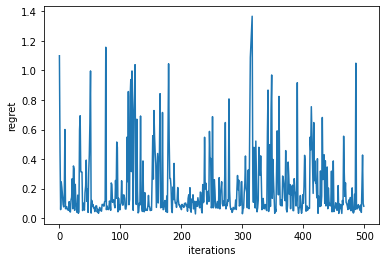

In [12]:
regret = simulate(logreg_sg, X, a, r, bidprices)
plt.plot(np.arange(len(regret)), regret)
plt.ylabel("regret")
plt.xlabel("iterations")

Text(0.5, 0, 'iterations')

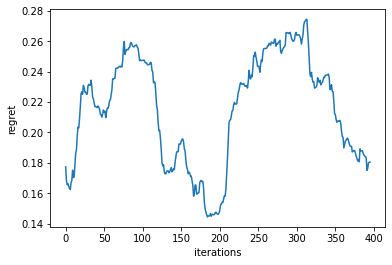

In [13]:
window_size=105
regret_smooth=np.convolve(regret,np.ones(window_size), 'valid')/window_size
plt.plot(np.arange(len(regret_smooth)), regret_smooth)
plt.ylabel("regret")
plt.xlabel("iterations")
# plt.ylim((0,0.3))

0.20725602608695654 0.10703043478260874


(array([24., 43., 54., 46., 58., 28., 24., 20.,  7., 17.,  7.,  9.,  6.,
        10.,  8.,  6., 10., 10.,  6.,  4.,  2., 11.,  2.,  1.,  1.,  3.,
         8.,  5.,  2.,  6.,  2.,  2.,  2.,  3.,  0.,  2.,  3.,  0.,  3.,
         4.,  1.,  1.,  3.,  0.,  1.,  0.,  3.,  1.,  2.,  4.,  0.,  1.,
         2.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  2.,  1.,  1.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  2.,  1.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.02853043, 0.04191883, 0.05530722, 0.06869561, 0.082084  ,
        0.09547239, 0.10886078, 0.12224917, 0.13563757, 0.14902596,
        0.16241435, 0.17580274, 0.18919113, 0.20257952, 0.21596791,
        0.2293563 , 0.2427447 , 0.25613309, 0.26952148, 0.28290987,
        0.29629826, 0.30968665, 0.32307504, 0.33646343, 0.34985183,
        0.36324022, 0.37662861, 0.390017  , 0.40340539, 0.41679378,
        0.43018217, 0.4435

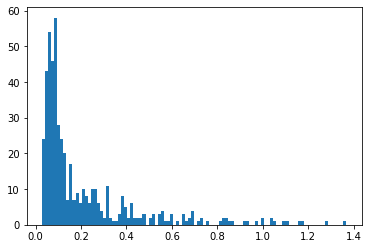

In [14]:
print (np.mean(regret), np.median(regret))
plt.hist(regret, bins=100)

In [15]:
print(X.columns)
pred = logreg_sg.predict(np.eye(len(X.columns)), output_score=True)
pred["bid"] = [bids[y] for y in pred['choice']]
pred

Index(['adNetworkId_41', 'adNetworkId_59', 'adNetworkId_96', 'adNetworkId_108',
       'adNetworkId_115', 'adNetworkId_141', 'adNetworkId_142',
       'adNetworkId_159', 'adNetworkId_172', 'adNetworkId_191',
       'adNetworkId_194', 'adNetworkId_215', 'adNetworkId_216',
       'adNetworkId_223', 'adNetworkId_228', 'adNetworkId_235',
       'adNetworkId_254', 'adNetworkId_278', 'adNetworkId_298',
       'adNetworkId_304', 'adNetworkId_307', 'adNetworkId_317',
       'adNetworkId_322', 'adNetworkId_332', 'adNetworkId_338',
       'adNetworkId_347', 'adNetworkId_356', 'adNetworkId_357',
       'adNetworkId_372', 'adNetworkId_385', 'adNetworkId_397',
       'adNetworkId_403', 'adNetworkId_404', 'adNetworkId_438',
       'adNetworkId_457', 'adNetworkId_495', 'adNetworkId_497',
       'adNetworkId_501', 'adNetworkId_507', 'adNetworkId_517',
       'adNetworkId_565', 'adNetworkId_581', 'adNetworkId_592',
       'adNetworkId_599', 'adNetworkId_600', 'adNetworkId_605',
       'adNetworkId_606'

{'choice': array([15, 14, 14, 17, 10, 16, 18, 10, 14,  8, 14, 41, 17, 23, 27,  8, 15,
        21, 24, 29, 23, 10, 25,  6,  5,  9, 15,  7,  7, 14, 14, 10, 19, 22,
        24, 14, 16, 18, 15, 18, 20, 19, 22, 38, 25, 14, 17, 15, 29,  7, 25,
         8,  6,  8, 11, 15, 20, 12, 15,  7, 19, 13, 19, 14, 23, 14, 15, 18,
        20, 19, 10, 24, 18, 14, 12, 11, 17, 27, 11, 10, 20, 14,  8,  8, 14,
        15, 11,  8, 15, 20, 14, 22, 16, 19, 10]),
 'score': array([[0.03200184],
        [0.09325426],
        [0.017071  ],
        [0.06879781],
        [0.06264965],
        [0.01440611],
        [0.02742906],
        [0.02949017],
        [0.02721282],
        [0.15123744],
        [0.02979952],
        [0.09758889],
        [0.03963655],
        [0.20104107],
        [0.11323631],
        [0.03684996],
        [0.09938555],
        [0.0277323 ],
        [0.15740507],
        [0.06331124],
        [0.01101459],
        [0.05474797],
        [0.1475311 ],
        [0.09009949],
        [0.02509953],
 

In [16]:
df.groupby("deviceOs").agg({"bidPrice": np.mean, "sessionId": 'count'})

,bidPrice,sessionId
deviceOs,,
Android,0.361349,19851
iOS,0.282460,13385


In [17]:
df.pivot_table(values="bidPrice", index="deviceOs", columns="hasWon", aggfunc='median')

hasWon,0,1
deviceOs,,
Android,0.1939,0.292371
iOS,0.1900,0.249880


In [18]:
df.pivot_table(values="bidPrice", index="size", columns="hasWon", aggfunc='median')

hasWon,0,1
size,,
300x250,0.252520,0.352420
320x50,0.192071,0.272508
728x90,0.180000,0.253305


In [19]:
df.query('hasWon==1').pivot_table(values="bidPrice", index="deviceOs", columns="size", aggfunc='median')

size,300x250,320x50,728x90
deviceOs,,,
Android,0.324626,0.290831,0.314338
iOS,0.394381,0.254197,0.217586


In [20]:
### TODO: Explode solution is nice but we have a lot of memory issues with it. It's hacky
# 1. Instead: For loop inside simulate >>> partial fit "on the fly"
# 2. Add loops of features and maybe think on other datasets
# 3. Make some presentation for Gil with some math
# 4. Work on presentation